**Group Members**
- Wachira James

- Tim Musungu

- Vivian Kwamboka

- Calvin Mutua

- Hashim Ibrahim
---
## Project Introduction
- Remote sensing imagery has been widely used for cropland extent classification, but existing products still contain high levels of uncertainty, making them less useful . 

- Machine learning and artificial intelligence can improve the accuracy of crop mapping and land cover classification using time-series satellite imagery. 

- The focus was on cropland mapping in dry regions, where the primary challenge lies in distinguishing cropland from pastures and steppe land.

We decided to develope an accurate and cost-effective method for cropland mapping in two test regions (Fergana in Uzbekistan and Orengurg in Russia), both of which present the unique complexities of arid and semi-arid agricultural landscapes.
## Project Objective
- We tackled the challenge of accurately identifying cropland in arid and semi-arid regions using satellite imagery and geospatial data. 
## Specific Objective
- The central goal was to develop a model that can automatically classify whether a given pixel or image region corresponds to cropland or not.

## Business Understanding
- The topic is deeply relevant due to its intersection with food security, environmental monitoring, and climate resilience. 
- As the global climate shifts and drylands expand, data-driven tools for agricultural mapping become increasingly vital. 
- For us, our work represents a confluence of technical interest in AI and a commitment to real-world impact, particularly in under-resourced regions.

## Data Understanding
- We used multi-temporal satellite imagery from Sentinel-1 (SAR) and Sentinel-2 (optical) sources. 
- The primary dataset includes labelled training data for cropland classification in the target regions.

**Key Dataset Features:**
- Multi-temporal satellite imagery from Sentinel-1 (radar) and Sentinel-2 (optical) sources
- Satellite reflectance and radar backscatter values at multiple time points
- Spectral bands from optical imagery
SAR backscatter measurements (VV, VH polarizations)
- Ground truth labels indicating cropland presence (binary classification: 0 or 1)


**Import necessary libraries**

In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
#import seaborn as sns

# Preprocessing
from sklearn.preprocessing import LabelEncoder

# import classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier 

# Model evaluation
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_val_score


## Data Preparation

**Preprocessing Training data**

In [5]:
import geopandas as gpd
import os

# Define file paths
fergana_path = r"Data\train_data\Fergana_training_samples.shp"
orenburg_path = r"Data\train_data\Orenburg_training_samples.shp"

# Check if files exist
if not os.path.exists(fergana_path):
	raise FileNotFoundError(f"File not found: {fergana_path}")
if not os.path.exists(orenburg_path):
	raise FileNotFoundError(f"File not found: {orenburg_path}")

# Load labeled training data
fergana_gdf = gpd.read_file(fergana_path)
orenburg_gdf = gpd.read_file(orenburg_path)

# Combine into one GeoDataFrame
train_gdf = pd.concat([fergana_gdf, orenburg_gdf], ignore_index=True)

# Assign WGS84 (lat/lon) if missing
train_gdf.set_crs(epsg=3857, inplace=True)

# Sort by geometry
train_gdf.sort_values(by='geometry', inplace=True)

print(train_gdf.columns)
print(train_gdf.head())


Index(['ID', 'Cropland', 'geometry'], dtype='object')
      ID  Cropland               geometry
735  236         0  POINT (55.802 50.991)
592   93         0  POINT (55.801 51.015)
535   36         0   POINT (55.79 51.122)
678  179         0    POINT (55.88 51.13)
521   22         0  POINT (55.898 51.111)


**Preprocessing Sentinel-1/2 Data for Modeling**

Our goals for Sentinel-1 (radar) and Sentinel-2(optical) data:

1.  Clean and structure the data.

2.  Handle time-series irregularity (interpolation).

3.  Normalize the data for machine learning models.


**Step 1: Load and Merge Datasets**
- Ensure both Sentinel-1 and Sentinel-2 datasets are joined by ID and date, aligning radar and optical data.


In [ ]:
from shapely.geometry import Point

# Upload the dataset
s1 = pd.read_csv('data/Sentinel1.csv')
s2 = pd.read_csv('data/Sentinel2.csv')

# Convert dates
s1['date'] = pd.to_datetime(s1['date'])
s2['date'] = pd.to_datetime(s2['date'])

# Merge by ID + nearest date within a small window 
sentinel_df = pd.merge_asof(
    s1.sort_values('date'),
    s2.sort_values('date'),
    by='ID',
    on='date',
    direction='nearest',
    tolerance=pd.Timedelta('3D')
)


sentinel_df.dropna(inplace=True)

# Convert sentinel_df to GeoDataFrame
geometry = [Point(xy) for xy in zip(sentinel_df['translated_lon_y'], sentinel_df['translated_lat_y'])]
sentinel_gdf = gpd.GeoDataFrame(sentinel_df, geometry=geometry, crs=train_gdf.crs)

# Perform spatial join to label Sentinel data with training labels
# Use nearest join to find closest training sample within 100m
labeled_data = gpd.sjoin_nearest(sentinel_gdf, train_gdf, how='inner', max_distance=100)

labeled_data.head()

,ID_left,VH,VV,date,orbit,polarization,rel_orbit,translated_lat_x,translated_lon_x,B11,...,B8A,cloud_pct,solar_azimuth,solar_zenith,translated_lat_y,translated_lon_y,geometry,index_right,ID_right,Cropland
5177,ID_TEJUWI,-24.014908,-14.979447,2021-07-06,DESCENDING,"[VV, VH]",78.0,40.687808,72.569937,3849.0,...,2953.0,14.391306,135.430065,22.756683,40.687513,72.569932,POINT (72.57 40.688),157,158,1
5178,ID_TEJUWI,-23.669992,-18.905448,2021-07-06,DESCENDING,"[VV, VH]",78.0,40.687728,72.569580,3849.0,...,2953.0,14.391306,135.430065,22.756683,40.687513,72.569932,POINT (72.57 40.688),157,158,1
5179,ID_TEJUWI,-24.377359,-17.233862,2021-07-06,DESCENDING,"[VV, VH]",78.0,40.687724,72.569697,3849.0,...,2953.0,14.391306,135.430065,22.756683,40.687513,72.569932,POINT (72.57 40.688),157,158,1
5180,ID_TEJUWI,-24.726874,-16.036720,2021-07-06,DESCENDING,"[VV, VH]",78.0,40.687721,72.569815,3849.0,...,2953.0,14.391306,135.430065,22.756683,40.687513,72.569932,POINT (72.57 40.688),157,158,1
5181,ID_BYNZOG,-12.176243,-8.757444,2021-07-06,DESCENDING,"[VV, VH]",78.0,41.503033,71.876930,2607.0,...,3635.0,0.719796,141.488570,22.039166,41.503243,71.877002,POINT (71.877 41.503),328,329,0


| Column              | Meaning                                                 | Why It Matters                                                           |
| ------------------- | ------------------------------------------------------- | ------------------------------------------------------------------------ |
| **B2**              | Band 2: **Blue light** (visible light spectrum)         | Good for water detection, useful in vegetation indexes                   |
| **B3**              | Band 3: **Green light**                                 | Enhances vegetation detection, health monitoring                         |
| **B4**              | Band 4: **Red light**                                   | Crucial for vegetation indexes (e.g., NDVI)                              |
| **B5 – B7**         | Bands 5–7: **Red Edge** (between red and near-infrared) | Sensitive to **plant stress**, health, and chlorophyll content           |
| **B8**              | Band 8: **Near-Infrared (NIR)**                         | Strongly reflects from healthy vegetation; used in vegetation analysis   |
| **B8A**             | Band 8A: Narrowband **NIR**                             | Similar to B8 but more precise for vegetation                            |
| **B11 – B12**       | Bands 11–12: **Short-Wave Infrared (SWIR)**             | Detects **moisture, soil properties**, and **crop water content**        |
| **ID**              | Matches Sentinel-1 ID for location                      | Used for merging/joining data between datasets                           |
| **cloud\_pct**      | **Cloud coverage percentage** of the image              | High cloud cover means lower data quality; may need to exclude or filter |
| **date**            | Observation date                                        | Enables **temporal analysis** (growth cycles, crop change)               |
| **solar\_azimuth**  | Sun’s **horizontal angle** at image time                | Helps adjust image lighting; minor in most models                        |
| **solar\_zenith**   | Sun’s **vertical angle** at image time                  | Related to image brightness and shadowing; can affect reflectance        |
| **translated\_lat** | Latitude                                                | Location coordinate                                                      |
| **translated\_lon** | Longitude                                               | Location coordinate                                                      |


In [7]:
labeled_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 1201531 entries, 5177 to 1744172
Data columns (total 28 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   ID_left           1201531 non-null  object        
 1   VH                1201531 non-null  float64       
 2   VV                1201531 non-null  float64       
 3   date              1201531 non-null  datetime64[ns]
 4   orbit             1201531 non-null  object        
 5   polarization      1201531 non-null  object        
 6   rel_orbit         1201531 non-null  float64       
 7   translated_lat_x  1201531 non-null  float64       
 8   translated_lon_x  1201531 non-null  float64       
 9   B11               1201531 non-null  float64       
 10  B12               1201531 non-null  float64       
 11  B2                1201531 non-null  float64       
 12  B3                1201531 non-null  float64       
 13  B4                1201531 non-null  

In [8]:
# Drop irrelevant columns
irrelevant_cols = ['index_right','ID_right','geometry', 'translated_lon_x', 'translated_lat_x','polarization']
labeled_data.drop(columns=irrelevant_cols, inplace=True)

# Encode categorical columns
label_encoder = LabelEncoder()
labeled_data['orbit_encoded'] = label_encoder.fit_transform(labeled_data['orbit'])

# Rename columns for clarity
labeled_data.rename(columns={
    'ID_left': 'location_ID',
    'translated_lon_y': 'lon',
    'translated_lat_y': 'lat',
    'ID_x': 'ID_left',
    'ID_y': 'ID_right'
}, inplace=True)

# Now labeled_data has Sentinel features + label column (e.g., 'crop_label')
labeled_data.info()


<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 1201531 entries, 5177 to 1744172
Data columns (total 23 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   location_ID    1201531 non-null  object        
 1   VH             1201531 non-null  float64       
 2   VV             1201531 non-null  float64       
 3   date           1201531 non-null  datetime64[ns]
 4   orbit          1201531 non-null  object        
 5   rel_orbit      1201531 non-null  float64       
 6   B11            1201531 non-null  float64       
 7   B12            1201531 non-null  float64       
 8   B2             1201531 non-null  float64       
 9   B3             1201531 non-null  float64       
 10  B4             1201531 non-null  float64       
 11  B5             1201531 non-null  float64       
 12  B6             1201531 non-null  float64       
 13  B7             1201531 non-null  float64       
 14  B8             1201531 non-n

**Step 2: Handle Missing Values & Interpolation**
- Satellite data may have gaps (e.g., cloudy Sentinel-2). For time series per location, interpolate missing values per feature:

In [9]:
# Filter out images with high cloud cover (>10%)
cloud_threshold = 10.0  # in percent
labeled_data = labeled_data[labeled_data['cloud_pct'] <= cloud_threshold]


labeled_data.info()


<class 'pandas.core.frame.DataFrame'>
Index: 902831 entries, 5181 to 1744172
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   location_ID    902831 non-null  object        
 1   VH             902831 non-null  float64       
 2   VV             902831 non-null  float64       
 3   date           902831 non-null  datetime64[ns]
 4   orbit          902831 non-null  object        
 5   rel_orbit      902831 non-null  float64       
 6   B11            902831 non-null  float64       
 7   B12            902831 non-null  float64       
 8   B2             902831 non-null  float64       
 9   B3             902831 non-null  float64       
 10  B4             902831 non-null  float64       
 11  B5             902831 non-null  float64       
 12  B6             902831 non-null  float64       
 13  B7             902831 non-null  float64       
 14  B8             902831 non-null  float64       
 15  B

**Step 3: Feature Engineering: Calculating Vegetation Indices**

- The following is a guide on vegetation indices:

| Index | Formula                                     | Use                                   |
| ----- | ------------------------------------------- | ------------------------------------- |
| NDVI  | (B8 - B4) / (B8 + B4)                       | Vegetation health, crop presence      |
| EVI   | 2.5 \* (B8 - B4) / (B8 + 6*B4 - 7.5*B2 + 1) | More robust to clouds/soil background |
| NDWI  | (B3 - B11) / (B3 + B11)                     | Water content in crops/soil           |
| SAVI  | (B8 - B4) / (B8 + B4 + 0.5) \* 1.5          | Like NDVI, but better in sparse cover |


❓ **Why Add 1e-6?**
- To avoid division by zero errors when the denominator is very small (can happen due to noise or zero values).
- It stabilizes computation without significantly affecting the result.

❓ **Time Series modelling**
- We can also aggregate our indices over time by calculating median indices per pixel ID over the season


In [10]:
# Calculate vegetation indices
labeled_data['NDVI'] = (labeled_data['B8'] - labeled_data['B4']) / (labeled_data['B8'] + labeled_data['B4'] + 1e-6)
labeled_data['EVI'] = 2.5 * (labeled_data['B8'] - labeled_data['B4']) / (labeled_data['B8'] + 6*labeled_data['B4'] - 7.5*labeled_data['B2'] + 1 + 1e-6)
labeled_data['NDWI'] = (labeled_data['B3'] - labeled_data['B11']) / (labeled_data['B3'] + labeled_data['B11'] + 1e-6)
labeled_data['SAVI'] = (labeled_data['B8'] - labeled_data['B4']) / (labeled_data['B8'] + labeled_data['B4'] + 0.5 + 1e-6)* 1.5

# Calculate seasonal median indices per pixel ID
seasonal_indices = labeled_data.groupby('location_ID').agg({
    'NDVI': 'median',
    'EVI': 'median',
    'NDWI': 'median',
    'SAVI': 'median'
}).reset_index()

labeled_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 902831 entries, 5181 to 1744172
Data columns (total 27 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   location_ID    902831 non-null  object        
 1   VH             902831 non-null  float64       
 2   VV             902831 non-null  float64       
 3   date           902831 non-null  datetime64[ns]
 4   orbit          902831 non-null  object        
 5   rel_orbit      902831 non-null  float64       
 6   B11            902831 non-null  float64       
 7   B12            902831 non-null  float64       
 8   B2             902831 non-null  float64       
 9   B3             902831 non-null  float64       
 10  B4             902831 non-null  float64       
 11  B5             902831 non-null  float64       
 12  B6             902831 non-null  float64       
 13  B7             902831 non-null  float64       
 14  B8             902831 non-null  float64       
 15  B

## Pre-processing

**Step 4: Feature Normalization**

- Per feature normalization (global): we use `Min-Max` Scaling.

- Per ID normalization: Normalize time series within each location (useful for relative comparison).

In [11]:
# per feature normalization
from sklearn.preprocessing import MinMaxScaler

features_to_scale = ['VH', 'VV', 'B2', 'B3', 'B4', 'B5','B6', 'B7','B8', 'B8A', 'B11', 'cloud_pct', 'solar_azimuth','solar_zenith', 'NDVI', 'EVI', 'NDWI', 'SAVI']

scaler = MinMaxScaler()
labeled_data[features_to_scale] = scaler.fit_transform(labeled_data[features_to_scale])

labeled_data.head()
# # per ID normalization --- IGNORE ---
# def normalize_group(group):
#     return (group - group.min()) / (group.max() - group.min() + 1e-6)

# normalized_df = labeled_data.copy()
# normalized_df[features_to_scale] = labeled_data.groupby('ID_left')[features_to_scale].transform(normalize_group)
#normalized_df.head()


,location_ID,VH,VV,date,orbit,rel_orbit,B11,B12,B2,B3,...,solar_azimuth,solar_zenith,lat,lon,Cropland,orbit_encoded,NDVI,EVI,NDWI,SAVI
5181,ID_BYNZOG,0.722084,0.630338,2021-07-06,DESCENDING,78.0,0.183096,1685.0,0.025371,0.047437,...,0.206456,0.02842,41.503243,71.877002,0,0,0.79513,5.474473e-07,0.236296,0.795413
5186,ID_BYNZOG,0.882492,0.813563,2021-07-06,DESCENDING,78.0,0.183096,1685.0,0.025371,0.047437,...,0.206456,0.02842,41.503243,71.877002,0,0,0.79513,5.474473e-07,0.236296,0.795413
5190,ID_BYNZOG,0.781078,0.697237,2021-07-06,DESCENDING,78.0,0.183096,1685.0,0.025371,0.047437,...,0.206456,0.02842,41.503243,71.877002,0,0,0.79513,5.474473e-07,0.236296,0.795413
5191,ID_BYNZOG,0.694612,0.648937,2021-07-06,DESCENDING,78.0,0.183096,1685.0,0.025371,0.047437,...,0.206456,0.02842,41.503243,71.877002,0,0,0.79513,5.474473e-07,0.236296,0.795413
5192,ID_BYNZOG,0.701942,0.664979,2021-07-06,DESCENDING,78.0,0.183096,1685.0,0.025371,0.047437,...,0.206456,0.02842,41.503243,71.877002,0,0,0.79513,5.474473e-07,0.236296,0.795413


**Exploratory Data Analysis: Check for Class Imbalance**

Cropland
0    0.689749
1    0.310251
Name: proportion, dtype: float64


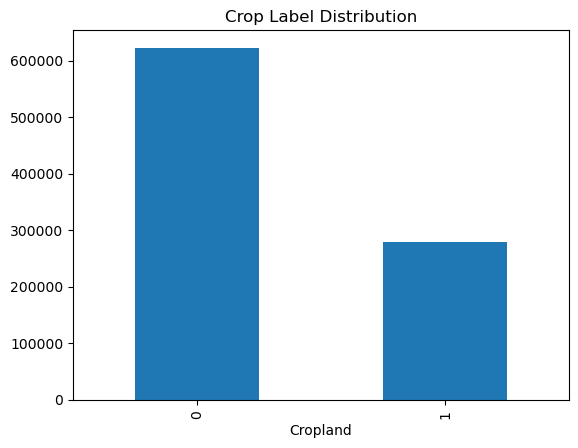

In [12]:
print(labeled_data['Cropland'].value_counts(normalize=True))

labeled_data.value_counts('Cropland').plot(kind='bar', title='Crop Label Distribution');   

- We observe a ***70/30*** split in the dataset for the binary label

- Our solution to this will be to apply undersampling using `RandomUnderSampler` in our modelling since the imbalance isn't severe 

## Data Modelling



### Training and Evaluation

In [13]:
# Define a Performance Evaluation Function

results = []

def evaluate_model(name, y_true, y_pred, results=[]):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    
    results.append({
        'Model': name,
        'Accuracy score': round(acc * 100, 2),
        'Weighted F1 score': round(f1_weighted * 100, 2)
    })
    return results

**Training our Baseline Model: `RandomForestClassifier`**

In [14]:
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN

features_to_train = ['VH', 'VV', 'B2', 'B3', 'B4', 'B5','B6', 'B7','B8', 'B8A', 'B11', 'cloud_pct', 'solar_azimuth','solar_zenith','orbit_encoded', 'NDVI', 'EVI', 'NDWI', 'SAVI']
#features_to_train = ['NDVI', 'EVI', 'NDWI', 'SAVI']

# Split by location_ID to ensure spatial independence
unique_ids = labeled_data['location_ID'].unique()
train_ids, test_ids = train_test_split(unique_ids, test_size=0.2, random_state=42)

train_data = labeled_data[labeled_data['location_ID'].isin(train_ids)]
test_data = labeled_data[labeled_data['location_ID'].isin(test_ids)]

X_train = train_data[features_to_train]
y_train = train_data['Cropland']
X_test = test_data[features_to_train]
y_test = test_data['Cropland']

# Train Random Forest Classifier (baseline model)
# no resampling
baseline_pipe= Pipeline([
        ('clf', RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42))
])

# with resampling
res_baseline_pipe= Pipeline([
    ('random_under', RandomUnderSampler(sampling_strategy='auto',random_state=42)),
    ('clf', RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42))
])

# Fit and evaluate the model
baseline_pipe.fit(X_train, y_train)
y_pred = baseline_pipe.predict(X_test)

res_baseline_pipe.fit(X_train, y_train)
y_pred_res = res_baseline_pipe.predict(X_test)

# Print evaluation metrics
evaluate_model('Random Forest (Baseline + no resampling)', y_test, y_pred, results)
evaluate_model('Random Forest (Baseline + resampling)', y_test, y_pred_res, results)

[{'Model': 'Random Forest (Baseline + no resampling)',
  'Accuracy score': 64.24,
  'Weighted F1 score': 59.18},
 {'Model': 'Random Forest (Baseline + resampling)',
  'Accuracy score': 64.25,
  'Weighted F1 score': 59.52}]

In [15]:
# Classification report
print("Classification Report (Baseline + no resampling):")
print(classification_report(y_test, y_pred, digits=5))   

print("Classification Report (Baseline + resampling):")
print(classification_report(y_test, y_pred_res, digits=5))

Classification Report (Baseline + no resampling):
              precision    recall  f1-score   support

           0    0.65012   0.90279   0.75590    110210
           1    0.59797   0.22935   0.33154     69482

    accuracy                        0.64239    179692
   macro avg    0.62405   0.56607   0.54372    179692
weighted avg    0.62996   0.64239   0.59181    179692

Classification Report (Baseline + resampling):
              precision    recall  f1-score   support

           0    0.65175   0.89584   0.75454    110210
           1    0.59301   0.24074   0.34245     69482

    accuracy                        0.64253    179692
   macro avg    0.62238   0.56829   0.54850    179692
weighted avg    0.62903   0.64253   0.59520    179692



In [16]:
results_df = pd.DataFrame(results)
print(results_df)

                                      Model  Accuracy score  Weighted F1 score
0  Random Forest (Baseline + no resampling)           64.24              59.18
1     Random Forest (Baseline + resampling)           64.25              59.52


---
**Results Summary**

- 



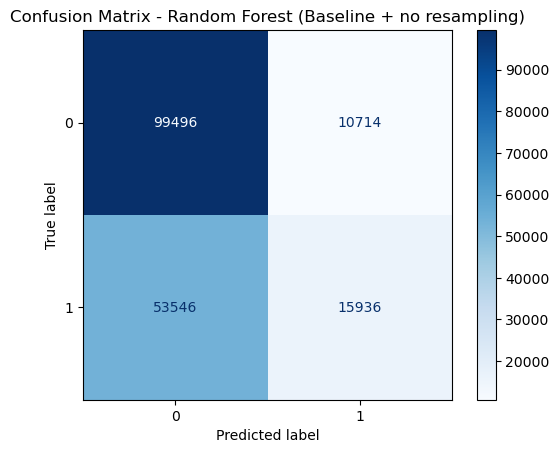

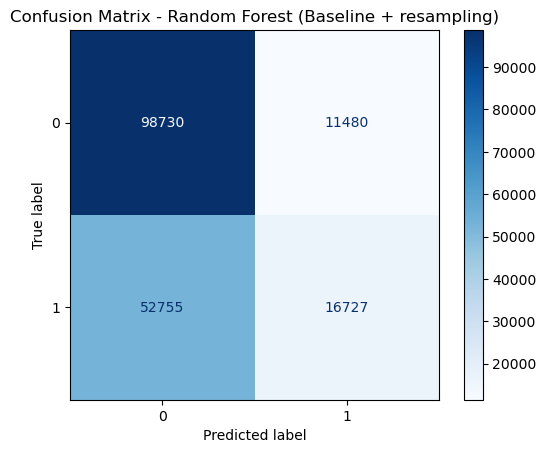

In [17]:
# Plot the confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=baseline_pipe.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Random Forest (Baseline + no resampling)')
plt.show();

cm_res = confusion_matrix(y_test, y_pred_res)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_res, display_labels=res_baseline_pipe.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Random Forest (Baseline + resampling)')
plt.show();


**Training Gradient Boosting Models: `XGBoost`**

In [19]:
# Train XGBoost Classifier
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler


xgb_pipe = Pipeline([
    ('xgb', XGBClassifier( n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='mlogloss'))
])

res_xgb_pipe = Pipeline([
    ('random_under', RandomUnderSampler(sampling_strategy='auto', random_state=42)),
    ('xgb', XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='mlogloss'))
])

# Fit and evaluate XGBoost model
xgb_pipe.fit(X_train, y_train)
xgb_pred = xgb_pipe.predict(X_test)
evaluate_model('XGBoost', y_test, xgb_pred, results)

res_xgb_pipe.fit(X_train, y_train)
xgb_pred_res = res_xgb_pipe.predict(X_test)
evaluate_model('XGBoost (Resampling)', y_test, xgb_pred_res, results)

print("Classification Report (XGBoost):")
print(classification_report(y_test, xgb_pred, digits=5))

print("Classification Report (XGBoost + Resampling):")
print(classification_report(y_test, xgb_pred_res, digits=5))

results_df = pd.DataFrame(results)
print(results_df)

c:\Users\USER\anaconda3\envs\geoenv\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:47:47] WARNING: D:\bld\xgboost-split_1754001889079\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\USER\anaconda3\envs\geoenv\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:47:51] WARNING: D:\bld\xgboost-split_1754001889079\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification Report (XGBoost):
              precision    recall  f1-score   support

           0    0.68400   0.88318   0.77093    110210
           1    0.65565   0.35281   0.45876     69482

    accuracy                        0.67810    179692
   macro avg    0.66982   0.61799   0.61484    179692
weighted avg    0.67304   0.67810   0.65022    179692

Classification Report (XGBoost + Resampling):
              precision    recall  f1-score   support

           0    0.73657   0.74605   0.74128    110210
           1    0.58880   0.57678   0.58273     69482

    accuracy                        0.68060    179692
   macro avg    0.66269   0.66142   0.66200    179692
weighted avg    0.67943   0.68060   0.67997    179692

                                      Model  Accuracy score  Weighted F1 score
0  Random Forest (Baseline + no resampling)           64.24              59.18
1     Random Forest (Baseline + resampling)           64.25              59.52
2                             

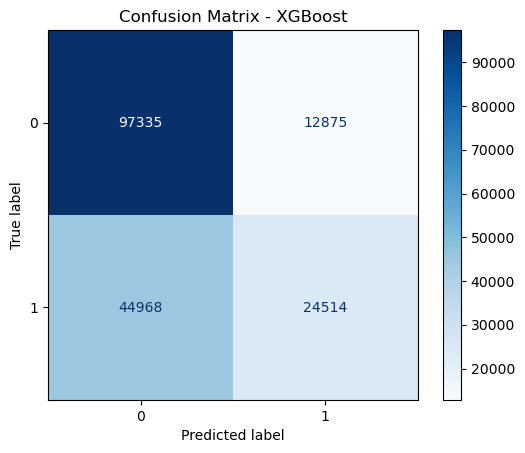

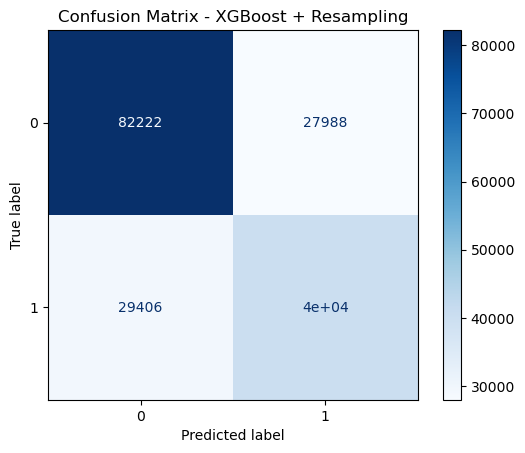

In [20]:
# Plot the confusion matrix XGBoost
cm_xgb = confusion_matrix(y_test, xgb_pred)
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=xgb_pipe.classes_)
disp_xgb.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - XGBoost')
plt.show();

cm_xgb = confusion_matrix(y_test, xgb_pred_res)
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=res_xgb_pipe.classes_)
disp_xgb.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - XGBoost + Resampling')
plt.show();

### HyperParameter Tuning using `RandomizedsearchCV`
#### Tuning `RandomForestClassifier`

In [21]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_grid = {
    'clf__n_estimators': randint(80, 120),
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4],
    'clf__class_weight': ['balanced', None]
}

random_search = RandomizedSearchCV(
    res_baseline_pipe,
    param_grid, cv=3,
    n_iter=5,  # Number of random combinations to try
    scoring='f1_weighted',  # Use weighted F1 score as the scoring metric
    verbose=2,
    n_jobs=-1,  # Use all available cores
    random_state=42
)   

# Fit the random search model
random_search.fit(X_train, y_train)
tuned_rf = random_search.predict(X_test)
evaluate_model('Random Forest (Tuned)', y_test, tuned_rf, results)

print('Classification Report (Random Forest Tuned):')
print(classification_report(y_test, tuned_rf, digits=5))

results_df = pd.DataFrame(results)
print(results_df)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Classification Report (Random Forest Tuned):
              precision    recall  f1-score   support

           0    0.67322   0.81795   0.73856    110210
           1    0.56182   0.37024   0.44634     69482

    accuracy                        0.64483    179692
   macro avg    0.61752   0.59409   0.59245    179692
weighted avg    0.63014   0.64483   0.62557    179692

                                      Model  Accuracy score  Weighted F1 score
0  Random Forest (Baseline + no resampling)           64.24              59.18
1     Random Forest (Baseline + resampling)           64.25              59.52
2                                   XGBoost           67.81              65.02
3                      XGBoost (Resampling)           68.06              68.00
4                     Random Forest (Tuned)           64.48              62.56


In [22]:
# Print out best estimators
print("Best parameters found: ", random_search.best_params_)
print("Best score: ", random_search.best_score_)

Best parameters found:  {'clf__class_weight': None, 'clf__max_depth': 20, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2, 'clf__n_estimators': 81}
Best score:  0.6853319044060512


## Neural Network
Because of the big gap of class imbalance, undersampling is one of the best ways to bridge the gap and introduce `Neural Network`

In [23]:
import pytorch_tabular
print(pytorch_tabular.__version__)


1.1.1


In [25]:
from pytorch_tabular.models.tab_transformer.config import TabTransformerConfig
help(TabTransformerConfig)


Help on class TabTransformerConfig in module pytorch_tabular.models.tab_transformer.config:

class TabTransformerConfig(pytorch_tabular.config.config.ModelConfig)
 |  TabTransformerConfig(task: str, head: Optional[str] = 'LinearHead', head_config: Optional[Dict] = <factory>, embedding_dims: Optional[List] = None, embedding_dropout: float = 0.0, batch_norm_continuous_input: bool = True, learning_rate: float = 0.001, loss: Optional[str] = None, metrics: Optional[List[str]] = None, metrics_prob_input: Optional[List[bool]] = None, metrics_params: Optional[List] = None, target_range: Optional[List] = None, virtual_batch_size: Optional[int] = None, seed: int = 42, _module_src: str = 'models.tab_transformer', _model_name: str = 'TabTransformerModel', _backbone_name: str = 'TabTransformerBackbone', _config_name: str = 'TabTransformerConfig', input_embed_dim: int = 32, embedding_initialization: Optional[str] = 'kaiming_uniform', embedding_bias: bool = False, share_embedding: bool = False, share

In [27]:
def run_training_example(df, categorical_cols, continuous_cols, target_col,
                         batch_size=256, max_epochs=10, lr=1e-3, device='cpu'):
    # preprocess
    df_proc, encs = prepare_dataframe_for_model(df, categorical_cols, continuous_cols, target_col)

    # compute cardinalities for each categorical
    categories_cardinalities = [int(df_proc[c].nunique()) for c in categorical_cols]

    # train/val split (stratify on target)
    train_df, valid_df = train_test_split(df_proc, test_size=0.2, stratify=df_proc[target_col], random_state=42)

    # datasets & loaders
    train_ds = TabularDataset(train_df, categorical_cols, continuous_cols, target_col)
    valid_ds = TabularDataset(valid_df, categorical_cols, continuous_cols, target_col)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(valid_ds, batch_size=batch_size, shuffle=False, num_workers=0)

    # model
    model = TabTransformer(
        categories_cardinalities=categories_cardinalities,
        num_continuous=len(continuous_cols),
        embedding_dim=32,
        cont_projection_dim=32,
        transformer_dim=128,
        transformer_heads=4,
        transformer_layers=2,
        mlp_hidden_dim=64,
        dropout=0.1,
        lr=lr,
    )

    # trainer (disable rich progress to avoid earlier IndexError)
    trainer = pl.Trainer(
        max_epochs=max_epochs,
        enable_progress_bar=False,   # disables rich progress bar
        logger=False,
        devices=1 if (device != 'cpu' and torch.cuda.is_available()) else None,
        accelerator='gpu' if (device != 'cpu' and torch.cuda.is_available()) else 'cpu'
    )

    trainer.fit(model, train_loader, val_loader)

    # Predict on validation set
    model.eval()
    ys = []
    ypreds = []
    yprobs = []
    with torch.no_grad():
        for cat, cont, y in val_loader:
            cat = cat.long()
            cont = cont.float()
            logits = model(cat, cont)
            probs = torch.sigmoid(logits)
            preds = (probs >= 0.5).long()
            ys.append(y.numpy())
            ypreds.append(preds.cpu().numpy())
            yprobs.append(probs.cpu().numpy())
    ys = np.concatenate(ys)
    ypreds = np.concatenate(ypreds)
    yprobs = np.concatenate(yprobs)

    # metrics
    print("Val accuracy:", accuracy_score(ys, ypreds))
    print("Val weighted F1:", f1_score(ys, ypreds, average='weighted'))
    print("\nClassification report:\n", classification_report(ys, ypreds, digits=5))
    return model, trainer, (ys, ypreds, yprobs), encs

In [28]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# Separate features and target
X = labeled_data.drop(columns=['Cropland'])  
y = labeled_data['Cropland']                 

# Check class distribution before undersampling
print("Before undersampling:", Counter(y))

# Perform undersampling
undersampler = RandomUnderSampler(random_state=42)
X_res, y_res = undersampler.fit_resample(X, y)

# Check class distribution after undersampling
print("After undersampling:", Counter(y_res))

# Create a balanced DataFrame
balanced_data = pd.concat([pd.DataFrame(X_res, columns=X.columns), 
                           pd.DataFrame(y_res, columns=['Cropland'])], axis=1)

print("\nBalanced dataset shape:", balanced_data.shape)


# balanced_data.to_csv("balanced_labeled_data.csv", index=False)


Before undersampling: Counter({0: 622727, 1: 280104})
After undersampling: Counter({0: 280104, 1: 280104})

Balanced dataset shape: (560208, 27)


In [29]:
balanced_data.head()

,location_ID,VH,VV,date,orbit,rel_orbit,B11,B12,B2,B3,...,solar_azimuth,solar_zenith,lat,lon,orbit_encoded,NDVI,EVI,NDWI,SAVI,Cropland
1315631,ID_HNNEYE,0.467303,0.585726,2024-08-19,DESCENDING,78.0,0.338579,4362.0,0.137191,0.185569,...,0.347984,0.196829,40.541751,71.751518,0,0.519509,5.452350e-07,0.395555,0.519638,0
524076,ID_GULKYZ,0.646230,0.598989,2022-07-25,DESCENDING,78.0,0.165742,1732.0,0.063189,0.091578,...,0.274659,0.080439,40.917197,71.719084,0,0.741641,5.492617e-07,0.397519,0.741900,0
995695,ID_GSAYNS,0.647411,0.611496,2023-10-24,DESCENDING,78.0,0.234666,2812.0,0.090353,0.115296,...,0.735028,0.589345,40.766444,71.527500,0,0.580797,5.461004e-07,0.369744,0.580962,0
601599,ID_TLNIVM,0.560873,0.633717,2022-10-05,DESCENDING,78.0,0.311530,3977.0,0.126853,0.168972,...,0.692763,0.477793,41.295191,72.477711,0,0.544122,5.454843e-07,0.393065,0.544267,0
948097,ID_RPVYCG,0.699241,0.682322,2023-09-06,DESCENDING,78.0,0.199115,1848.0,0.061554,0.090107,...,0.432549,0.285924,40.654172,71.542944,0,0.807988,5.491366e-07,0.350803,0.808293,0


In [30]:
!pip install tensorflow scikit-learn --quiet

In [31]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Split into features & target

X = labeled_data.drop(columns=['Cropland', 'location_ID', 'date'])
y = labeled_data['Cropland']

# Identify categorical columns
categorical_cols = X.select_dtypes(include=['object']).columns
print("Categorical columns:", categorical_cols)


# 2. Encode categorical columns

le = LabelEncoder()
for col in categorical_cols:
    X[col] = le.fit_transform(X[col])

# 3. Train/test split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 4. Scale features

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# 5. Build Neural Network

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # for binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


# 6. Train model

model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


# 7. Evaluate

loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")


Categorical columns: Index(['orbit'], dtype='object')


c:\Users\USER\anaconda3\envs\geoenv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
22571/22571 ━━━━━━━━━━━━━━━━━━━━ 151s 6ms/step - accuracy: 0.7820 - loss: 0.4035 - val_accuracy: 0.8101 - val_loss: 0.3570
Epoch 2/20
22571/22571 ━━━━━━━━━━━━━━━━━━━━ 150s 7ms/step - accuracy: 0.8210 - loss: 0.3448 - val_accuracy: 0.8234 - val_loss: 0.3440
Epoch 3/20
22571/22571 ━━━━━━━━━━━━━━━━━━━━ 163s 7ms/step - accuracy: 0.8314 - loss: 0.3274 - val_accuracy: 0.8371 - val_loss: 0.3218
Epoch 4/20
22571/22571 ━━━━━━━━━━━━━━━━━━━━ 146s 6ms/step - accuracy: 0.8391 - loss: 0.3139 - val_accuracy: 0.8445 - val_loss: 0.3051
Epoch 5/20
22571/22571 ━━━━━━━━━━━━━━━━━━━━ 156s 7ms/step - accuracy: 0.8468 - loss: 0.3010 - val_accuracy: 0.8495 - val_loss: 0.2976
Epoch 6/20
22571/22571 ━━━━━━━━━━━━━━━━━━━━ 154s 7ms/step - accuracy: 0.8540 - loss: 0.2896 - val_accuracy: 0.8623 - val_loss: 0.2811
Epoch 7/20
22571/22571 ━━━━━━━━━━━━━━━━━━━━ 173s 8ms/step - accuracy: 0.8607 - loss: 0.2796 - val_accuracy: 0.8641 - val_loss: 0.2723
Epoch 8/20
22571/22571 ━━━━━━━━━━━━━━━━━━━━ 162s 7ms/step - ac

In [32]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype("int32")  # for binary classification

print(classification_report(y_test, y_pred_classes))
print(confusion_matrix(y_test, y_pred_classes))


5643/5643 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step
              precision    recall  f1-score   support

           0       0.94      0.94      0.94    124255
           1       0.87      0.87      0.87     56312

    accuracy                           0.92    180567
   macro avg       0.91      0.91      0.91    180567
weighted avg       0.92      0.92      0.92    180567

[[117089   7166]
 [  7113  49199]]


So far, the Neural Network is our best performing Model with pretty high precision and f1-score for the two classes and a recall of 94% and 87% for class 0 and 1 respecttively

In [33]:
import pickle

# Save model as .pkl
with open("neural_network.pkl", "wb") as f:
    pickle.dump(model, f)

print("✅ Neural network saved as neural_network.pkl")


✅ Neural network saved as neural_network.pkl


In [ ]:
# conda env export > environment.yml



Note: you may need to restart the kernel to use updated packages.


In [ ]:
# conda list --export > requirements.txt



Note: you may need to restart the kernel to use updated packages.


### Business Recommendations
1. Targeted Field Verification

    Use the model outputs to identify areas most likely to be cropland and prioritize them for on-ground inspections. This minimizes time and costs by focusing only where confirmation is needed.

2. Optimized Resource Allocation

Allocate irrigation, fertilizer, and pest control resources based on high-confidence cropland areas. This ensures investments go where they will have the most impact.

3. Early-Warning for Land-Use Changes

Deploy the model quarterly to detect changes in cropland coverage. This enables timely response to encroachment, land degradation, or shifts in agricultural activity.

## Conclusion
Our analysis successfully classified cropland in arid and semi-arid regions with a 92% accuracy rate. This means that, in 92 out of 100 cases, our model can correctly distinguish cropland from non-cropland using satellite imagery. While some classification errors remain (~7k false positives and ~7k false negatives in the test set), the model’s overall reliability is strong enough to support operational decision-making.